In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import shapefile as shp
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [3]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names   = list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'amoc'
year      = [1958,2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = None

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#_____________________________________________________________________________________
which_lat         = 26.5 # 'max' # 'max', 26.0
which_transf      = 'dmoc'
do_zcoord         = False
do_useZinfo       = 'std_dens_H' #from where provide zinfo for projection to zcoord, options: 'std_dens_H', 'density_dMOC', 'std_dens_Z'

ncol              = 2      # number of pannel columns in figure
nrow              = None
plt_opt           = dict({'marker':'o'})
do_concat         = False 
do_enum           = False  # do enumeration of panels
do_shdw           = False
do_mean           = True
do_std            = False
do_enum           = False  # do enumeration of panels
save_dpi          = 300
save_fmt          = ['png']
do_bolus          = True #True/False
#do_rapid          = False

# these parameters are not needed here but need to be defined for papermill 
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_reffig         = False   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
do_ucell          = True   # do time series of upper amoc cell 
do_lcell          = False  # do time series of lower amoc cell 

In [2]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    from dask import config as cfg
    cfg.set({'distributed.scheduler.worker-ttl': None})
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

 --> memory_limit: 4.167 GB


/albedo/home/pscholz/.conda/envs/py38/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42405 instead
  warnings.warn(


In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (n_cycl is not None): 
    cycl_s=1 if do_allcycl else n_cycl
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, n_cycl+1):
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
#     #__________________________________________________________________________________________________
#     if (ref_path is not None): 
#         aux_path, aux_name = list(), list()
#         ref_path_old, ref_name_old = ref_path, ref_name
#         for ii_cycl in range(cycl_s, n_cycl+1):
#             aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
#             if not do_allcycl: aux_name.append('{}'.format(ref_name))
#             else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
#             print('R', ref_path[-1])        
#         ref_path, ref_name = aux_path, aux_name
#     del(aux_path, aux_name)  
    
##______________________________________________________________________________________________________        
# cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path is not None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record    
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
#     ref_cinfo['cref']=0.0 

#______________________________________________________________________________________________________
if not isinstance(which_lat, list): which_lat = list([which_lat])        

## ______________________________________________________________________________________________________    
## concatenate list = list1+list2
# if (ref_path is not None): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths        , ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names
  
#______________________________________________________________________________________________________
if not isinstance(which_lat[0], float) and not isinstance(which_lat[0], int): do_rapid=False
else:    
    if np.abs(which_lat[0]-26.5)>1.0: do_rapid=False

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


### ATTENTION:
use here the density MOC levels that are specfic for your run. They might be different from the one im using here since they might need to be customized specific to your hydrography to be able to cover the whole density range in your simulation. So check the code you are using (see. gen_modules_diag.F90)

In [5]:
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]


In [6]:
zdefuc,zdeflc = [200,3000], [800, 6000]
ddefuc,ddeflc = [36.0, 36.80], [36.0, 37.8]

data_list     = list()
year_list     = list(range(year[0], year[1]+1))
chnk_size     = 10  # compute dmoc time-series in chunks of chnk_size years 
                   #-> you can use larger chunks here if you have enough memory
chnk_yrs_list = year_list[::chnk_size]
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    
    print(' > year:', end='')
    ts = clock.time()
    
    # compute dmoc time series in chunk of year, to prevent matrices from becoming to big and you run out of memory !!!
    # you can play with chnk_size for the case you run out of memory 
    for nchnk, year_s in enumerate(chnk_yrs_list): 
        year_chnk = [ year_s, np.min([year_s+chnk_size-1,year[1]]) ]  
        print(*np.arange(year_chnk[0],year_chnk[1]+1), sep='|',end='\n        ')
         
        #____________________________________________________________________________________________________
        # load DMOC std_* data --> combined in xarray dataset
        data = tpv.load_dmoc_data(mesh, datapath, descript, year_chnk, which_transf, std_dens, do_info=False, 
                                  do_tarithm=None, do_zcoord=do_zcoord, do_useZinfo=do_useZinfo, 
                                  do_bolus=do_bolus, add_bolus=True, do_load=False, do_persist=True, )
        #__________________________________________________________________________________________________    
        # check if data where loaded
        if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
        #____________________________________________________________________________________________________
        # compute moc profile over time
        dmoc      = tpv.calc_dmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, do_load=True,
                                  do_parallel=do_parallel, n_workers=parallel_nprc_bin)
        #____________________________________________________________________________________________________
        # compute time-series
        
        # --> if the correct information for density class z position is available define upper lower cell 
        # by depth criteria zdefuc,zdeflc
        if 'ndens_zfh' in list(dmoc.keys()):
            if  vname == 'ipmoc' or vname == 'pmoc':
                dmoc_tchnk = dmoc.where((dmoc['ndens_zfh']>=zdeflc[0]) & (dmoc['ndens_zfh']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
            elif vname == 'amoc' or vname == 'aamoc':
                dmoc_nadw  = dmoc.where((dmoc['ndens_zfh']>=zdefuc[0]) & (dmoc['ndens_zfh']<=zdefuc[1])).max(dim='ndens',skipna=True).rename({'dmoc':'dmoc_nadw'})
                dmoc_aabw  = dmoc.where((dmoc['ndens_zfh']>=zdeflc[0]) & (dmoc['ndens_zfh']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
                dmoc_tchnk = xr.merge([dmoc_nadw,dmoc_aabw], compat='minimal' )
                del(dmoc_aabw, dmoc_nadw)
        # --> if there is no correct information for density class z position define upper lower cell 
        # by density criteria ddefuc,ddeflc
        else:
            if  vname == 'ipmoc' or vname == 'pmoc':
                dmoc_tchnk = dmoc.where((dmoc['ndens']>=ddeflc[0]) & (dmoc['ndens']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
            elif vname == 'amoc' or vname == 'aamoc':
                dmoc_nadw  = dmoc.where((dmoc['ndens']>=ddefuc[0]) & (dmoc['ndens']<=zdefuc[1])).max(dim='ndens',skipna=True).rename({'dmoc':'dmoc_nadw'})
                dmoc_aabw  = dmoc.where((dmoc['ndens']>=ddeflc[0]) & (dmoc['ndens']<=zdeflc[1])).min(dim='ndens',skipna=True).rename({'dmoc':'dmoc_aabw'})
                dmoc_tchnk = xr.merge([dmoc_nadw,dmoc_aabw], compat='minimal' )
                del(dmoc_aabw, dmoc_nadw)
        if nchnk==0: dmoc_t = dmoc_tchnk
        else       : dmoc_t = xr.concat([dmoc_t, dmoc_tchnk], dim='time')
        
        #____________________________________________________________________________________________________
        del(data, dmoc, dmoc_tchnk)
        
    #____________________________________________________________________________________________________
    # moctseries_list.append([time, moc_t])    
    data_list.append(dmoc_t)    
    print('        elapsed time: {:3.2f}min.'.format((clock.time()-ts)/60.0))
    del(dmoc_t)

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|2007
        2008|2009|2010|2011|2012
        2013|2014|2015|2016|2017
        2018|2019
                elapsed time: 2.09min.
/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 > year:1958|1959|1960|1961|1962
        1963|1964|1965|1966|1967
        1968|1969|1970|1971|1972
        1973|1974|1975|1976|1977
        1978|1979|1980|1981|1982
        1983|1984|1985|1986|1987
        1988|1989|1990|1991|1992
        1993|1994|1995|1996|1997
        1998|1999|2000|2001|2002
        2003|2004|2005|2006|

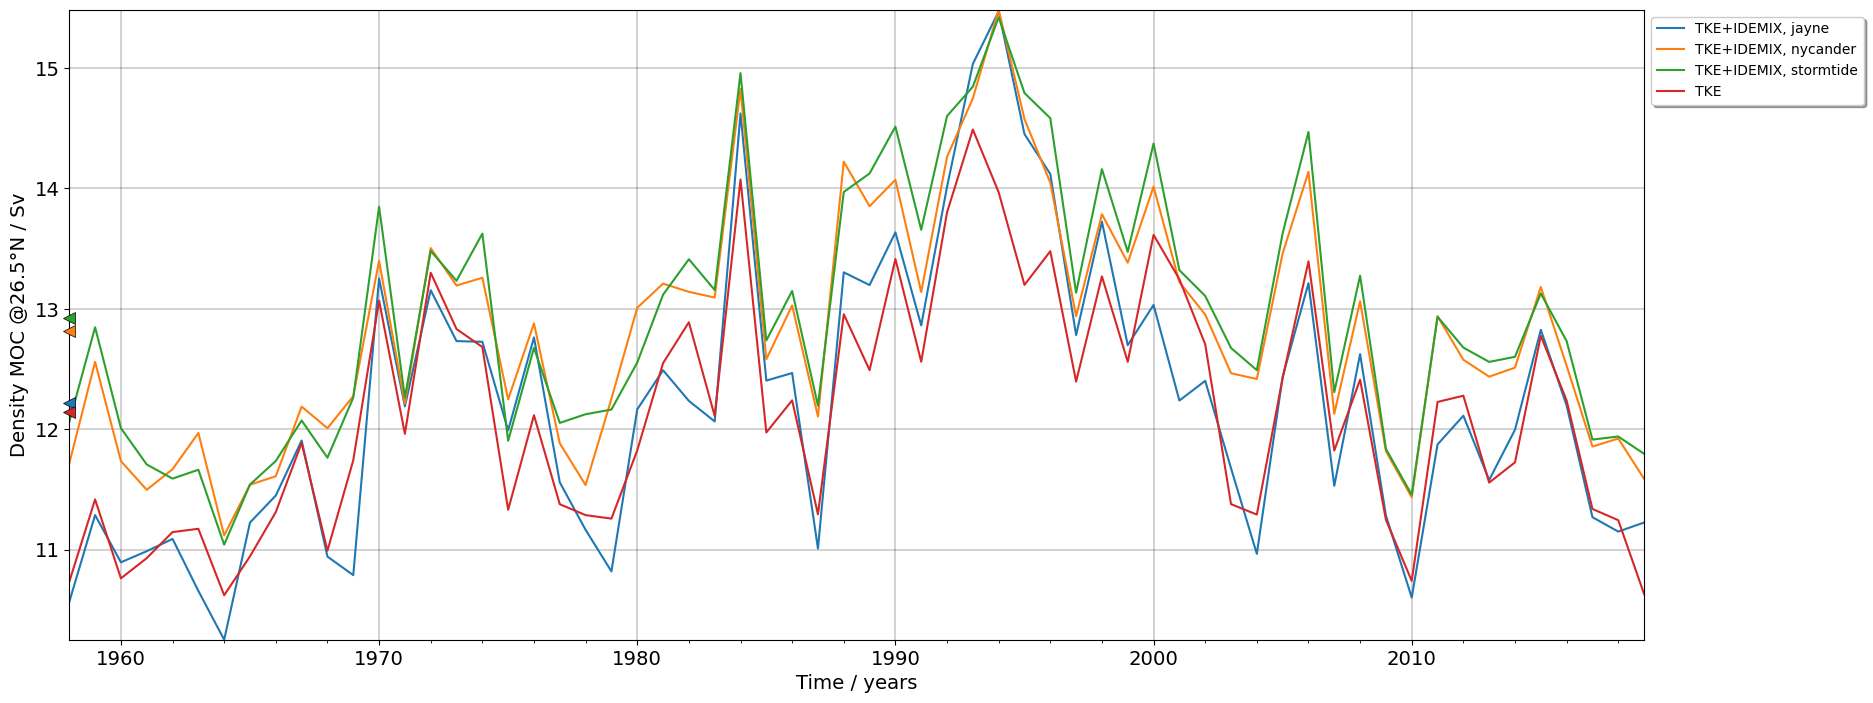

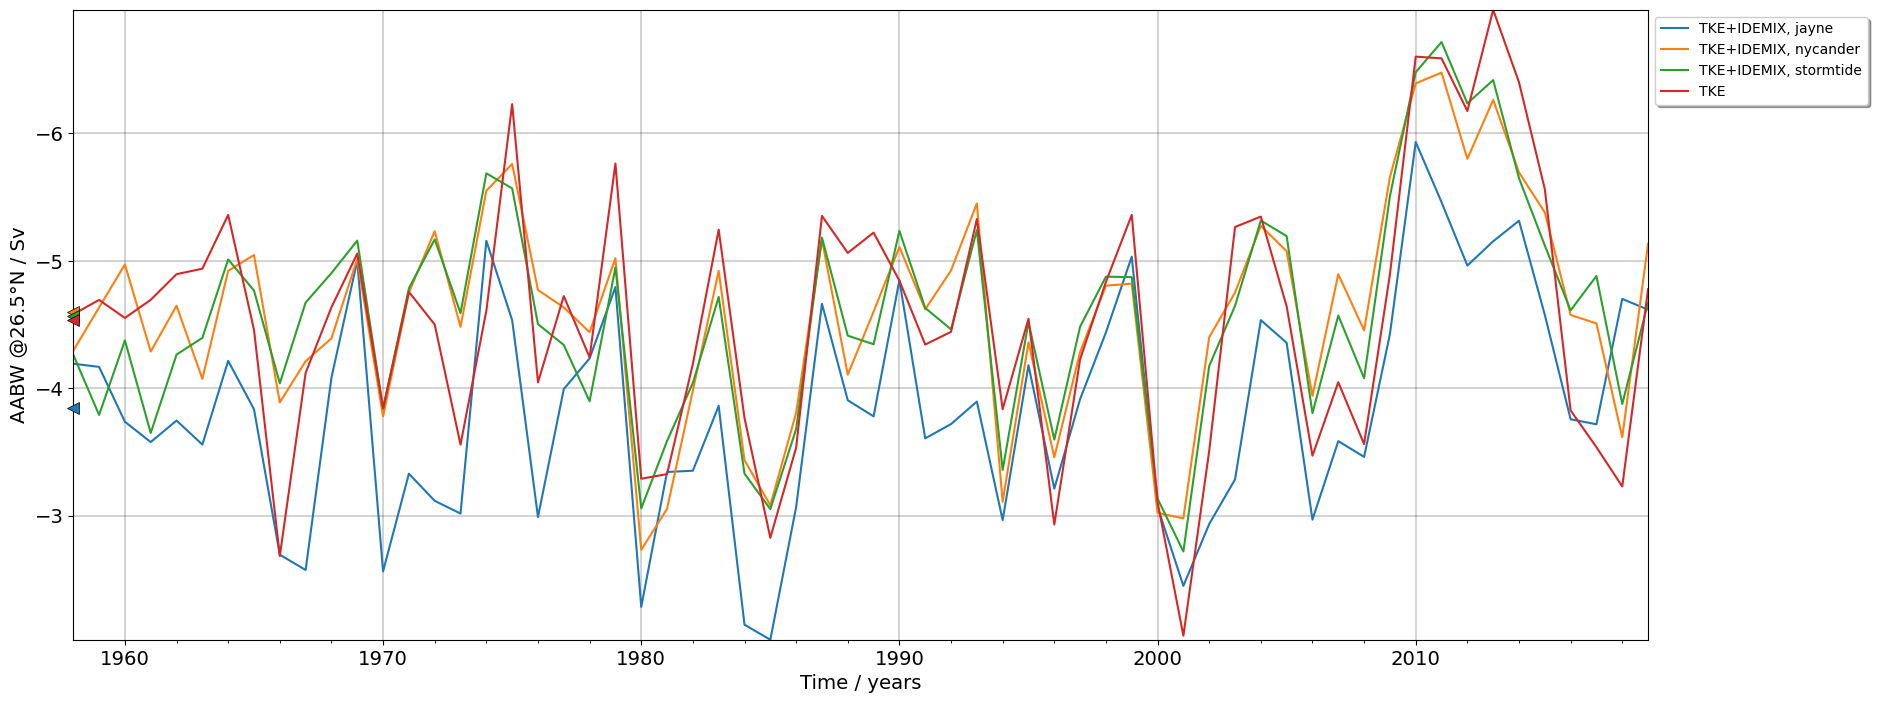

In [10]:
#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AMOC at lat
if do_ucell:
    for lat in which_lat: 
        lat_list = list()
        for data in data_list:
            for var in data.data_vars:
                #_______________________________________________________________
                if var in ['dmoc_nadw','dmoc_ucell']:
                    data_lat = data[var].to_dataset(promote_attrs=True)
                    if lat=='max':
                        data_lat = data_lat.isel(lat=(data.lat>40) & (data.lat<60)).max(dim='lat') 
                        str_label= f'@{40}°N<lat<{60}°N'
                    elif isinstance(lat, list):    
                        data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).max(dim='lat') 
                        str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                    else:     
                        data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                        if lat>=0: str_label= f'@{lat}°N'
                        else     : str_label= f'@{lat}°S'  
                    data_lat[var].attrs['add2ylabel'] = str_label
                    lat_list.append([data_lat])        

        #___PLOT TRANSECT__________________________________________________________________________________
        svname = list(lat_list[0][0].data_vars)[0]
        slabel = lat_list[0][0][svname].attrs['str_lsave']
        stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
        #__________________________________________________________________________________________________
        # do save filename path
        spath  = save_path
        sfpath = None
        if spath!=None: 
            sfpath=list()
            for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'dmoc_t_ucell', stname ,slabel, sfmt)) )
        if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
        
        #__________________________________________________________________________________________________
        fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                                n_cycl     = n_cycl                  , 
                                do_allcycl = do_allcycl              , 
                                do_concat  = do_concat               , 
                                do_shdw    = do_shdw                 ,
                                do_mean    = do_mean                 ,
                                do_std     = do_std                  ,
                                ax_opt     = dict({'fig_sizefac':4}) ,
                                do_enum    = do_enum                 ,
                                do_save    = sfpath, save_dpi=save_dpi, 
                             )            

#___PLOT FESOM2 DATA________________________________________________________
# plot strength of AABW at lat
if do_lcell:
    for lat in which_lat: 
        lat_list = list()
        for data in data_list:
            for var in data.data_vars:
                #_______________________________________________________________
                if var in ['dmoc_aabw','dmoc_lcell']:
                    data_lat = data[var].to_dataset(promote_attrs=True)
                    if lat=='max':
                        data_lat = data_lat.isel(lat=(data.lat>-20) & (data.lat<60)).min(dim='lat') 
                        str_label= f'@{-20}°S<lat<{60}°N'
                    elif isinstance(lat, list):    
                        data_lat = data_lat.isel(lat=(data.lat>lat[0]) & (data.lat<lat[1])).min(dim='lat') 
                        str_label= f'@{lat[0]}°N<lat<{lat[1]}°N'
                    else:     
                        data_lat = data_lat.isel(lat=np.argmin(np.abs(data.lat.data-lat)))
                        if lat>=0: str_label= f'@{lat}°N'
                        else     : str_label= f'@{lat}°S'  
                    data_lat[var].attrs['add2ylabel'] = str_label
                    data_lat[var].attrs['short_name'] = 'AABW'
                    data_lat[var].attrs['long_name']  = 'AABW'
                    lat_list.append([data_lat])        

        #___PLOT TRANSECT__________________________________________________________________________________
        svname = list(lat_list[0][0].data_vars)[0]
        slabel = lat_list[0][0][svname].attrs['str_lsave']
        stname = lat_list[0][0][svname].attrs['short_name'].replace(' ','_').lower()
        #__________________________________________________________________________________________________
        # do save filename path
        spath  = save_path
        sfpath = None
        if spath!=None: 
            sfpath=list()
            for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'dmoc_t_lcell', stname ,slabel, sfmt)) )
        if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
        
        #__________________________________________________________________________________________________
        fig,ax=tpv.plot_tline(lat_list, None, nrow=1, ncol=1 , 
                                n_cycl     = n_cycl                  , 
                                do_allcycl = do_allcycl              , 
                                do_concat  = do_concat               , 
                                do_shdw    = do_shdw                 ,
                                do_mean    = do_mean                 ,
                                do_std     = do_std                  ,
                                ax_opt     = dict({'fig_sizefac':4}) ,
                                grid_opt   = dict({'do_yinvert':True}),
                                do_enum    = do_enum                  ,
                                do_save    = sfpath, save_dpi=save_dpi, 
                             )

In [ ]:
if do_papermill and do_parallel and client_runs:
    client.shutdown()
    client_runs = False